# *Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset.

## Load the data

In [110]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head(1)

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating


## Clean obvious stuff

In [111]:
# Remove all dates from the reviews with a regex pattern.

shops["full_review_text"].replace(
    {'\d+[\/:\-]\d+[\/:\-\s]*[\dAaPpMm]*' : '', '\w+\s\d+[\,]\s\d+' : '', ' 1 ' : ''},
    regex=True,
    inplace=True,
)

# Remove extra words in star_rating.
shops["star_rating"] = shops["star_rating"].str.replace(' star rating', '')

# Cast ratings as floats.
shops['star_rating'] = shops['star_rating'].astype(float)

In [112]:
shops.head(1)

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,check-in Love love loved the atmosphere! Ever...,5.0


## Get tokens, but exclude custom stopwords

In [113]:
# Extend Spacy's stopwords.
STOP_WORDS = nlp.Defaults.stop_words.union([
    ' ', '  ', 'check-in', "i'm", "it's", "i've",
    'place', 'coffee', 'coffee.', 'austin', '-'
])

In [114]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

# Get tokens, but exclude stopwords.
tokens = []
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = []
    for token in doc:
        token = token.text.lower()
        if token not in STOP_WORDS:
            doc_tokens.append(token)
    tokens.append(doc_tokens)

# Create column of lists of tokens.
shops['tokens'] = tokens

## Update tokens by removing uncommon words

In [115]:
from collections import Counter

# Function that takes a corpus and returns a dataframe of word counts.
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [116]:
# Get list of words used in < 2.5% of reviews.
wc = count(shops['tokens'])
wc = wc[wc['appears_in_pct'] < 0.025]
uncommon_words = wc['word'].tolist()

In [117]:
# Update tokens by excluding stopwords AND uncommon words.
tokens = []
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = []
    for token in doc:
        token = token.text.lower()
        if token not in STOP_WORDS and token not in uncommon_words:
            doc_tokens.append(token)
    tokens.append(doc_tokens)

# Create column of lists of tokens.
shops['tokens'] = tokens

## Get lemmas

In [122]:
def get_lemmas(tokens):
    lemmas = []
    doc = nlp(str(tokens))
    for token in doc:
        if ((token.is_punct == False) and (token.pos_!= 'PRON')):
            lemmas.append(token.lemma_)
    return lemmas

shops['lemmas'] = shops['tokens'].apply(get_lemmas)

In [125]:
shops[['tokens', 'lemmas']].head()

,tokens,lemmas
0,"[love, love, loved, shop, ordered, getting, dr...","[love, love, love, shop, order, get, drink, pr..."
1,"[listed, austin,, love, definitely, pretty, :)...","[list, austin, love, definitely, pretty, proba..."
2,"[listed, loved, decor, doesn't, want, drink, w...","[list, love, decor, do, not, want, drink, wort..."
3,"[cool, good, drinks, nice, seating, 3, almond,...","[cool, good, drink, nice, seating, 3, almond, ..."
4,"[plenty, loved, friendly, easy, &, wanted, ord...","[plenty, love, friendly, easy, want, order, ch..."


## Visualize common words in 'good' & 'bad' reviews

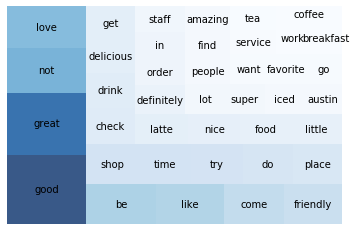

In [154]:
import squarify
import matplotlib
import matplotlib.pyplot as plt

# Good reviews have five stars.
good_reviews = shops[shops.star_rating == 5]
good_words = count(good_reviews['lemmas'])
top_good = good_words[good_words['rank'] <= 40]
pct_totals = top_good['pct_total']

# Create a color palette.
cmap = matplotlib.cm.Blues
mini=min(pct_totals)
maxi=max(pct_totals)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in pct_totals]

# Show plot of top 40 words common to good reviews.
squarify.plot(
    sizes=pct_totals,
    label=top_good['word'],
    alpha=.8,
    color=colors
)
plt.axis('off')
plt.show()

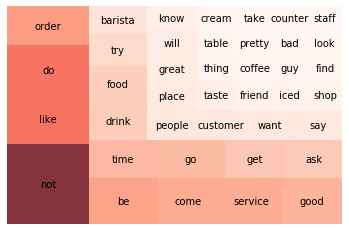

In [157]:
# Bad reviews have one star.
bad_reviews = shops[shops.star_rating == 1]
bad_words = count(bad_reviews['lemmas'])
top_bad = bad_words[bad_words['rank'] <= 40]
pct_totals = top_bad['pct_total']

cmap = matplotlib.cm.Reds
mini=min(pct_totals)
maxi=max(pct_totals)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in pct_totals]

squarify.plot(
    sizes=pct_totals,
    label=top_bad['word'],
    alpha=.8,
    color=colors
)
plt.axis('off')
plt.show()

## Summary
- Coffee shops that get good reviews are described as 'delicious', 'great', and 'amazing'. At this point in the analysis, we don't know the context of those words. On the other hand, shops that recieve negative reviews are often described as 'bad'. The word 'not' is used with a greater proportional frequency in bad reviews than good reviews. This kind of analysis seems shakey and doesn't tell us more than common sense: that bad service and gross drinks lead to negative reviews. Maybe looking at n-grams will help contextualize some of these frequent words.